In [87]:
# import libraries
import glob
import pandas as pd
import seaborn as sn
import datetime
import matplotlib.pylab as plt
import itertools
import matplotlib.ticker as ticker
import numpy as np

In [88]:
# get the absolute path of all Excel files 
all_excel_files = glob.glob("data/Device*.xlsx")

# read all Excel files at once
original_devices_df = pd.concat(pd.read_excel(excel_file) for excel_file in all_excel_files)
original_devices_df = original_devices_df.drop_duplicates()
original_devices_df.describe()


/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78462f60a200>>
Traceback (most recent call last):
  File "/home/amarton/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


,Organization,License plate No.,Vehicle color,Device model,Encryption chip ID,Positioning module,Host & peripheral version No.,Host & peripheral version No..1,Host & peripheral version No..2,Host & peripheral version No..3,...,Storage module4.5,Storage module4.6,Peripheral status1,Peripheral status1.1,Peripheral status1.2,Peripheral status2,Peripheral status2.1,Peripheral status2.2,Update time,Offline time
count,25610,32770,32770,22347,32770,22131,2,21705,21272,21266,...,404,1,1730,1730,1730,1730,1730,1730,22347,12651
unique,265,32765,2,14,32770,3,2,85,12,8,...,4,1,3,3,1728,3,3,1728,12179,11349
top,LATAM M1N,007100743D,Others,X1N_AI-M1N_TKH,Encryption chip ID,GPS,Hardware,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,7,Energized duration (H),OBD data analysis status,Parsing failed,2024-04-03 13:53:47,OBD authorization status,Authorized,2024-04-03 13:53:47,2024-04-03 16:15:03,2023-08-21 02:36:34
freq,6867,2,32769,17008,1,22120,1,8893,9775,9444,...,390,1,1726,1726,2,1726,1726,2,79,29


In [89]:
# fleets_of_interest = ["Quickway Dist - 1508","H R Ewell - 4094","Saddle Creek Corp - 2303","Shaw Regional - 1333","Shaw IPT - 1331","Shaw OTR - 2108","Boise Cascade - 4241","CRC Transport - 8114" ]
# fleets_of_interest = ["H R Ewell - 4094","Saddle Creek Corp - 2303"]
# fleets_of_interest = ["LATAM M1N"]
fleets_of_interest = ["Shaw Regional - 1333","Shaw IPT - 1331","Shaw OTR - 2108"]

In [90]:
devices_df = original_devices_df.copy()
# devices_df = devices_df[(devices_df["Device model"] == "X1N_AI-M1N_TKH")]
# devices_df = devices_df[(devices_df["Device model"] != "X1N_AI-M1N_TKH") & (devices_df["Device model"] != "M1N_TKH")]

devices_df = devices_df[(devices_df["Organization"].isin(fleets_of_interest))]
devices_df = devices_df[['Organization','License plate No.', 'Device model', 'Update time ']]
# devices_df = devices_df.drop(0, axis=0)
devices_df = devices_df.dropna()
display(devices_df)

,Organization,License plate No.,Device model,Update time
10413,Shaw Regional - 1333,0071004850,X1N_AI-M1N_TKH,2024-03-20 14:46:26
10451,Shaw OTR - 2108,00710044FC,X1N_AI-M1N_TKH,2024-04-03 16:14:01
10452,Shaw OTR - 2108,00710044D0,X1N_AI-M1N_TKH,2024-04-03 15:49:04
10454,Shaw Regional - 1333,007100461C,X1N_AI-M1N_TKH,2024-04-03 15:47:49
10456,Shaw OTR - 2108,00710046BF,X1N_AI-M1N_TKH,2024-04-03 16:14:08
...,...,...,...,...
26278,Shaw Regional - 1333,0071010059,X1N_AI-M1N_TKH,2024-04-03 13:16:34
26289,Shaw Regional - 1333,00710100D0,X1N_AI-M1N_TKH,2024-04-03 16:15:40
26296,Shaw Regional - 1333,00710100C2,X1N_AI-M1N_TKH,2024-04-03 16:15:59
26306,Shaw Regional - 1333,007101002B,X1N_AI-M1N_TKH,2024-04-03 16:15:36


In [ ]:

# get the absolute path of all Excel files 
all_excel_files = glob.glob("data/Alarm*.xlsx")

# read all Excel files at once
original_alarms_df = pd.concat(pd.read_excel(excel_file) for excel_file in all_excel_files)
original_alarms_df = original_alarms_df.drop_duplicates()


/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:

In [91]:
#Drop columns with NaN
start_date = datetime.datetime(year=2024, month=1, day=1)
end_date = datetime.datetime(year=2024, month=3, day=31)
alarms_df = original_alarms_df.copy()
alarms_df = alarms_df.drop_duplicates()

alarms_df = alarms_df[alarms_df["Type"] == "Video Loss Alarm"]
# alarms_df = alarms_df.drop(columns=["Alarm evidence", "Alarm level", "Category", "Alarm status", "Driver", "Driver employee ID", "Label", "Day"])
alarms_df = alarms_df[["Type","License plate number","Fleet","Device number","Speed","Alarm time"]]
alarms_df = alarms_df.sort_values('Alarm time')
alarms_df["Alarm time"] = pd.to_datetime(alarms_df["Alarm time"],yearfirst=True)

alarms_df = alarms_df[(alarms_df["Alarm time"]>=start_date) & (alarms_df["Alarm time"]<=end_date)]
alarms_df = alarms_df.dropna()
alarms_df = alarms_df[alarms_df["License plate number"].isin(devices_df["License plate No."])]
display(alarms_df)


,Type,License plate number,Fleet,Device number,Speed,Alarm time
135809,Video Loss Alarm,0071005DAA,Shaw OTR - 2108,0071005DAA,0mph,2024-01-01 10:58:53
134496,Video Loss Alarm,00710058DF,Shaw Regional - 1333,00710058DF,0mph,2024-01-01 15:27:06
134407,Video Loss Alarm,0071004457,Shaw Regional - 1333,0071004457,2mph,2024-01-01 15:44:50
134406,Video Loss Alarm,007100561F,Shaw Regional - 1333,007100561F,1mph,2024-01-01 15:44:51
134247,Video Loss Alarm,007100558E,Shaw OTR - 2108,007100558E,0mph,2024-01-01 16:22:19
...,...,...,...,...,...,...
31,Video Loss Alarm,007100461C,Shaw Regional - 1333,007100461C,13mph,2024-03-28 10:46:58
30,Video Loss Alarm,007100461C,Shaw Regional - 1333,007100461C,41mph,2024-03-28 11:31:03
29,Video Loss Alarm,007100461C,Shaw Regional - 1333,007100461C,2mph,2024-03-28 14:57:49
28,Video Loss Alarm,007100461C,Shaw Regional - 1333,007100461C,64mph,2024-03-28 18:00:00


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,count,1.0,2.0,12.5,105.25,257.0


,License plate number,count
0,0071000081,3
1,0071003F94,2923
2,0071004042,2
3,007100404F,54
4,00710040D4,2
...,...,...
203,007101002B,270
204,0071010049,1
205,0071010059,8
206,00710100B6,1


,License plate number,count
1,0071003F94,2923
9,0071004137,2857
20,00710043AC,4941
24,0071004457,13981
32,007100454B,738
39,007100461C,3706
41,0071004652,2442
49,0071004746,1164
65,0071004C88,7697
67,0071004D55,2786


,Type,License plate number,Fleet,Device number,Speed,Alarm time
135809,Video Loss Alarm,0071005DAA,Shaw OTR - 2108,0071005DAA,0mph,2024-01-01 10:58:53
134496,Video Loss Alarm,00710058DF,Shaw Regional - 1333,00710058DF,0mph,2024-01-01 15:27:06
134406,Video Loss Alarm,007100561F,Shaw Regional - 1333,007100561F,1mph,2024-01-01 15:44:51
134247,Video Loss Alarm,007100558E,Shaw OTR - 2108,007100558E,0mph,2024-01-01 16:22:19
134200,Video Loss Alarm,0071005DAA,Shaw OTR - 2108,0071005DAA,68mph,2024-01-01 16:33:10
...,...,...,...,...,...,...
6673,Video Loss Alarm,0071005CE8,Shaw Regional - 1333,0071005CE8,0mph,2024-03-23 11:40:39
4713,Video Loss Alarm,0071005968,Shaw Regional - 1333,0071005968,0mph,2024-03-23 14:04:11
2904,Video Loss Alarm,0071005968,Shaw Regional - 1333,0071005968,0mph,2024-03-23 17:04:24
2380,Video Loss Alarm,0071005A9A,Shaw OTR - 2108,0071005A9A,0mph,2024-03-23 18:00:00


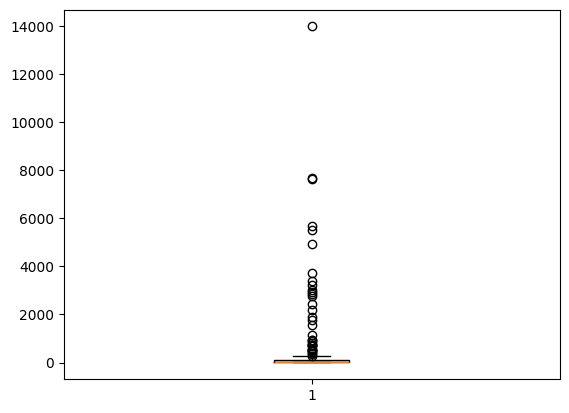

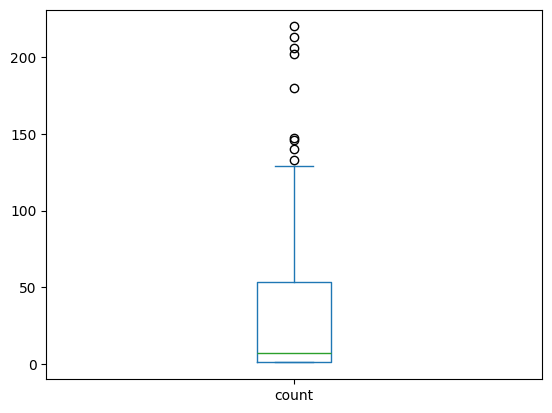

In [92]:
#REMOVE OUTLIER DEVICES
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

camera_failure_freq = alarms_df.groupby(["License plate number"])["License plate number"].value_counts()
camera_failure_freq = camera_failure_freq.to_frame().reset_index()
bp = plt.boxplot(camera_failure_freq['count'])
bp_info = get_box_plot_data(['count'],bp)
display(bp_info)
display(camera_failure_freq)
# #Show outlier devices for separate analysis
outlier_devices = camera_failure_freq[camera_failure_freq['count']>bp_info['upper_whisker'][0]]
display(outlier_devices)

filtered_devices = camera_failure_freq[camera_failure_freq['count']<bp_info['upper_whisker'][0]]

filtered_devices.plot.box()
# Remove outliers
alarms_df = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
devices_df = devices_df[~ devices_df["License plate No."].isin(outlier_devices["License plate number"])]
alarms_df.describe()
alarms_df

In [93]:
#NUMBER OF FAILURES PER DEVICE AND DATE

num_failures = alarms_df.copy()
num_failures["Alarm time"] = pd.to_datetime(num_failures["Alarm time"],yearfirst=True)

date_grouper = num_failures["Alarm time"].dt.date

num_failures = num_failures.groupby(['License plate number', date_grouper])["Type"].value_counts()
num_failures = num_failures.to_frame().reset_index().rename(columns={"count":"Failures", "Alarm time":"Date"})
num_failures_by_device_date = num_failures.pivot(index="License plate number", columns="Date", values="Failures").reset_index()

display(num_failures_by_device_date)



Date,License plate number,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-05,2024-01-06,2024-01-14,2024-01-15,2024-01-16,...,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-23
0,0071000081,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0071004042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,007100404F,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,2.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN
3,00710040D4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0071004107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0071010028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,0071010049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,0071010059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,00710100B6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
#FILTERING BY UPDATE TIME OF DEVICES

#Filtering to get only active devices during the period
active_devices_df = devices_df.copy()
active_devices_df = active_devices_df.rename(columns={"Update time ":"Active time"})
active_devices_df["Active time"] = pd.to_datetime(active_devices_df["Active time"],yearfirst=True)
# active_devices_df = active_devices_df[(active_devices_df["Active time"]>(alarms_df["Alarm time"].min()))]
alarms_df = alarms_df[(alarms_df["License plate number"].isin(active_devices_df["License plate No."]))]

display(alarms_df)

,Type,License plate number,Fleet,Device number,Speed,Alarm time
135809,Video Loss Alarm,0071005DAA,Shaw OTR - 2108,0071005DAA,0mph,2024-01-01 10:58:53
134496,Video Loss Alarm,00710058DF,Shaw Regional - 1333,00710058DF,0mph,2024-01-01 15:27:06
134406,Video Loss Alarm,007100561F,Shaw Regional - 1333,007100561F,1mph,2024-01-01 15:44:51
134247,Video Loss Alarm,007100558E,Shaw OTR - 2108,007100558E,0mph,2024-01-01 16:22:19
134200,Video Loss Alarm,0071005DAA,Shaw OTR - 2108,0071005DAA,68mph,2024-01-01 16:33:10
...,...,...,...,...,...,...
6673,Video Loss Alarm,0071005CE8,Shaw Regional - 1333,0071005CE8,0mph,2024-03-23 11:40:39
4713,Video Loss Alarm,0071005968,Shaw Regional - 1333,0071005968,0mph,2024-03-23 14:04:11
2904,Video Loss Alarm,0071005968,Shaw Regional - 1333,0071005968,0mph,2024-03-23 17:04:24
2380,Video Loss Alarm,0071005A9A,Shaw OTR - 2108,0071005A9A,0mph,2024-03-23 18:00:00


,Fleet,Devices with video loss,Available devices,Percentage
0,Shaw IPT - 1331,15,71,21.126761
1,Shaw OTR - 2108,28,121,23.140496
2,Shaw Regional - 1333,130,506,25.691700


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,Percentage,21.126761,22.133628,23.140496,24.416098,25.6917


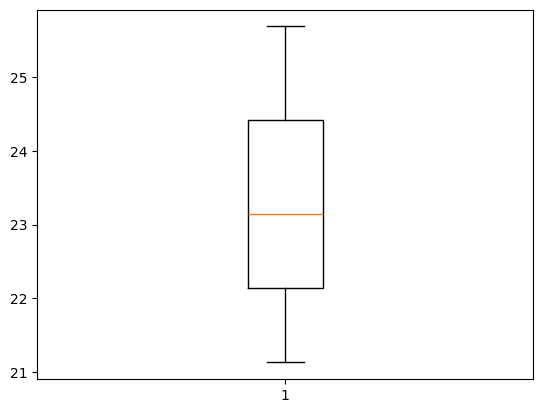

In [95]:
num_failed_devices_by_fleet = alarms_df.copy()

num_failed_devices_by_fleet = num_failed_devices_by_fleet.groupby(['Fleet'])["License plate number"].nunique()
num_available_devices_by_fleet = active_devices_df.groupby(['Organization'])["License plate No."].nunique()
result = pd.concat([num_failed_devices_by_fleet,num_available_devices_by_fleet], axis=1, join="inner")
result = result.reset_index().rename(columns={"index":"Fleet", "License plate number":"Devices with video loss", "License plate No.":"Available devices"})
result["Percentage"] = 100*result["Devices with video loss"]/result["Available devices"]
display(result)
bp = plt.boxplot(result['Percentage'])
bp_info = get_box_plot_data(['Percentage'],bp)
display(bp_info)

# outlier_organizations = result[(result["Percentage"]>bp_info['upper_whisker'][0]) | (result["Percentage"]<bp_info['lower_whisker'][0])]
# active_devices_df = active_devices_df[~ active_devices_df["Organization"].isin(outlier_organizations["Fleet"])]
# display(outlier_organizations)


In [96]:
# Analise do 4094 e 2303
# Histograma de distribuição dos devices/alarme
# Histograma agrupado por mês das falhas (Jan, Fev, Mar)
# Analise alarms/velocidade (histograma)


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,Failures,1.0,2.0,8.0,25.75,61.0


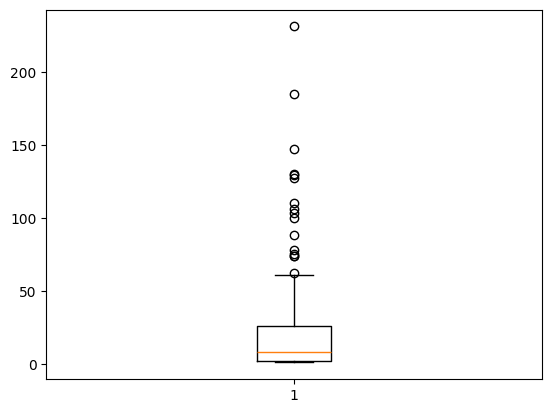

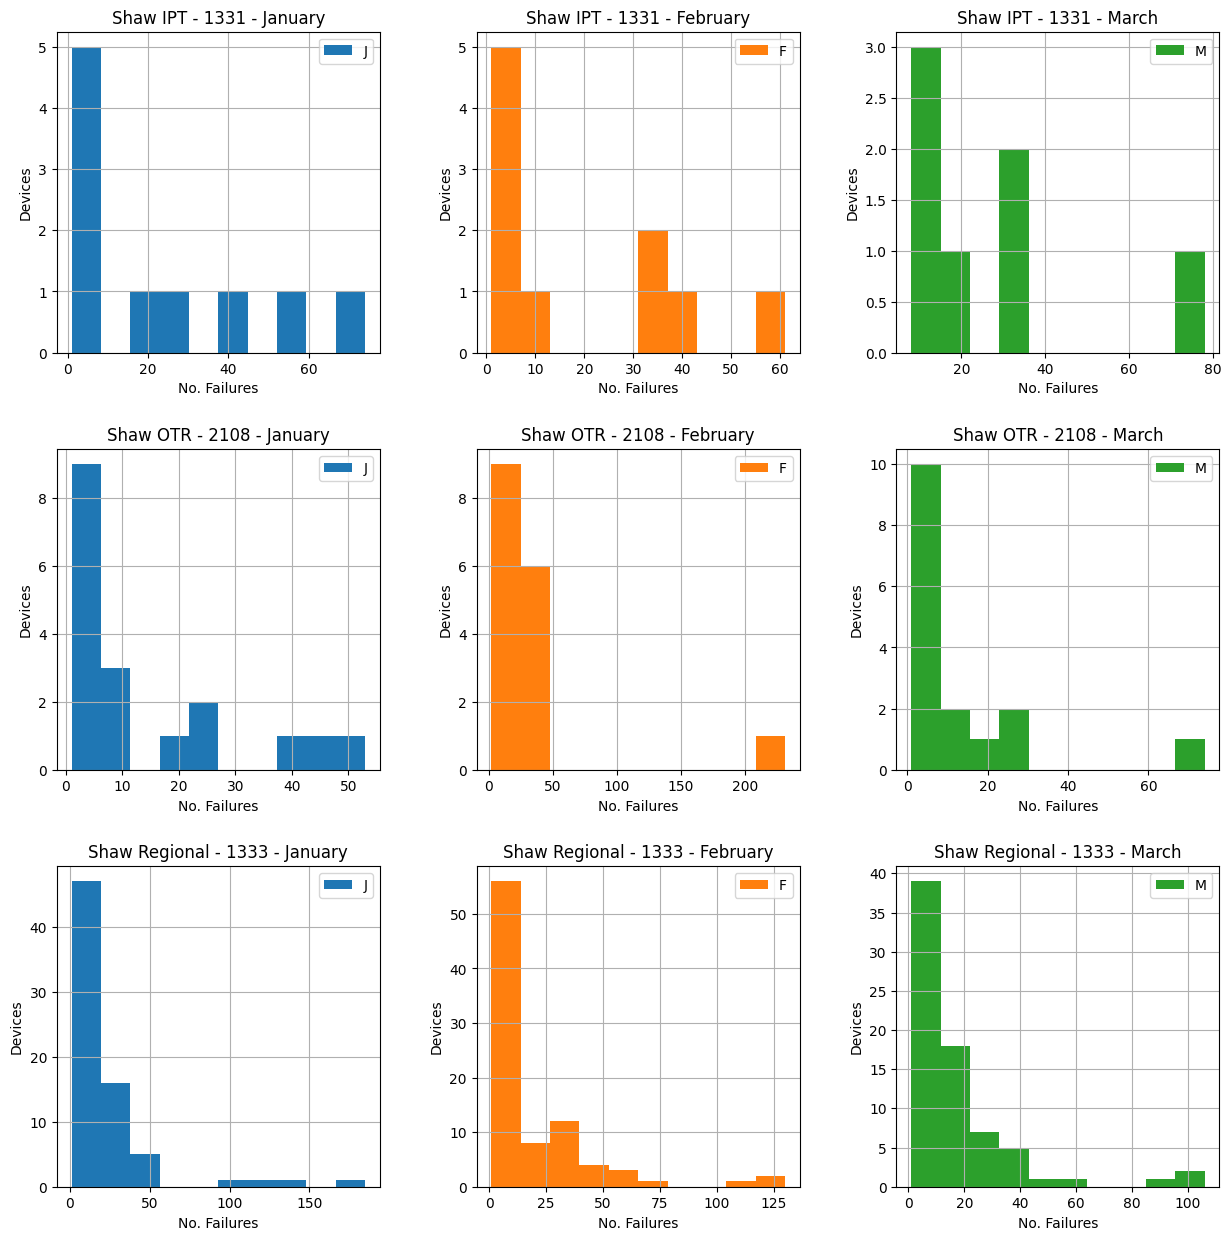

In [97]:
#DEVICE FAILURES GROUPED BY MONTH FOR EACH FLEET
grouper_month = alarms_df["Alarm time"].dt.month_name()
alarms_grouped_df = alarms_df.groupby([grouper_month, "Fleet"])["License plate number"].value_counts()
alarms_grouped_df = alarms_grouped_df.to_frame().reset_index().rename(columns={"count":"Failures", "Alarm time":"Month"})

#Rove monthly outliers
bp = plt.boxplot(alarms_grouped_df['Failures'])
bp_info = get_box_plot_data(['Failures'],bp)
display(bp_info)

#Remove monthly outliers
# outlier_devices = alarms_grouped_df[alarms_grouped_df['Failures']>bp_info['upper_whisker'][0]]
alarms_grouped_df = alarms_grouped_df[~ alarms_grouped_df["License plate number"].isin(outlier_devices["License plate number"])]
devices_grouped_df = devices_df[~ devices_df["License plate No."].isin(outlier_devices["License plate number"])]
# display(outlier_devices)
alarms_grouped_fleet_moth = alarms_grouped_df.pivot(index=["Fleet","License plate number"], columns="Month", values="Failures").reset_index()

fleets = alarms_grouped_df["Fleet"].unique()
months = sorted(alarms_grouped_df["Month"].unique(), key=lambda m: datetime.datetime.strptime(m, "%B"))

fig, axs = plt.subplots(len(fleets), len(months), figsize=(5*len(months), 5*len(fleets)))

i=0
for fleet_name in fleets :
    palette = itertools.cycle(sn.color_palette())
    j=0
    for month_name in months :
        hist_color = next(palette)
        data_fleet_month = alarms_grouped_df[(alarms_grouped_df["Fleet"]==fleet_name) & (alarms_grouped_df["Month"]==month_name)]
        data_fleet_month.hist(ax=axs[i,j], color=hist_color)
        plt.sca(axs[i,j])
        axs[i,j].set_ylabel("Devices")
        axs[i,j].set_xlabel("No. Failures")
        axs[i,j].set_title(fleet_name+' - '+month_name)
        axs[i,j].legend(month_name)
        # plt.xticks(np.arange(0, 50, step=5))
        # plt.yticks(np.arange(0, 50, step=5))

        j=j+1
    i=i+1

# display(alarms_grouped_df)

Text(0.5, 0, 'Speed (mph)')

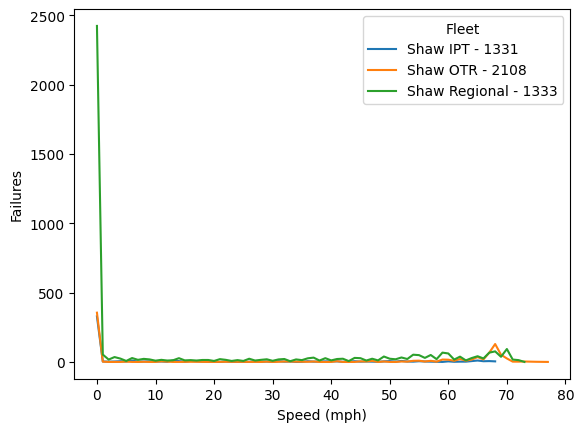

In [98]:

# Analise alarms/velocidade (histograma)
alarms_group_by_speed = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
alarms_group_by_speed["Speed"] = alarms_group_by_speed["Speed"].str.replace("mph","")
alarms_group_by_speed["Speed"] = alarms_group_by_speed["Speed"].astype(int)

alarms_group_by_speed = alarms_group_by_speed.groupby(["Fleet","Speed"])["Speed"].value_counts()
alarms_group_by_speed = alarms_group_by_speed.to_frame().reset_index().rename(columns={"count":"Failures"})

plot_ = sn.lineplot(alarms_group_by_speed, x="Speed",y="Failures",hue="Fleet")
new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
plt.xlabel("Speed (mph)")


Text(0.5, 1.0, 'Video losses in movement')

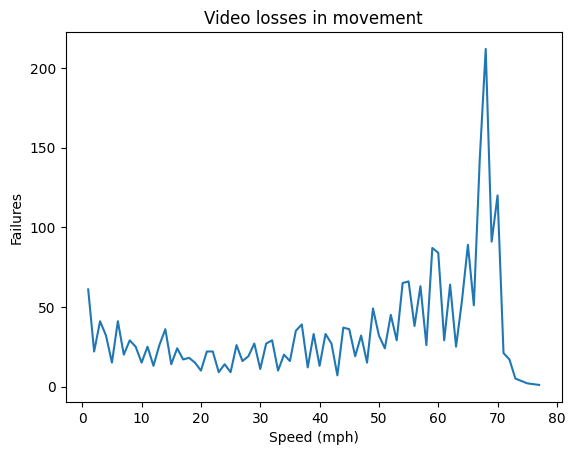

In [99]:
#Agrupar veiculos parados/em movimento
#Histograma
#Listar 10 veiculos para analise
alarms_speed_df = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
alarms_speed_df["Speed"] = alarms_speed_df["Speed"].str.replace("mph","")
alarms_speed_df["Speed"] = alarms_speed_df["Speed"].astype(int)
alarms_vehicles_moving = alarms_speed_df[alarms_speed_df["Speed"] > 0]


alarms_group_by_speed_moving = alarms_vehicles_moving.groupby(["Speed"])["Speed"].value_counts()
alarms_group_by_speed_moving = alarms_group_by_speed_moving.to_frame().reset_index().rename(columns={"count":"Failures"})

plot_ = sn.lineplot(alarms_group_by_speed_moving, x="Speed",y="Failures")
new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
# plt.xticks(np.arange(0, 80, step=10))
# plt.yticks(np.arange(0, 80, step=10))
plt.xlabel("Speed (mph)")
plt.title("Video losses in movement")



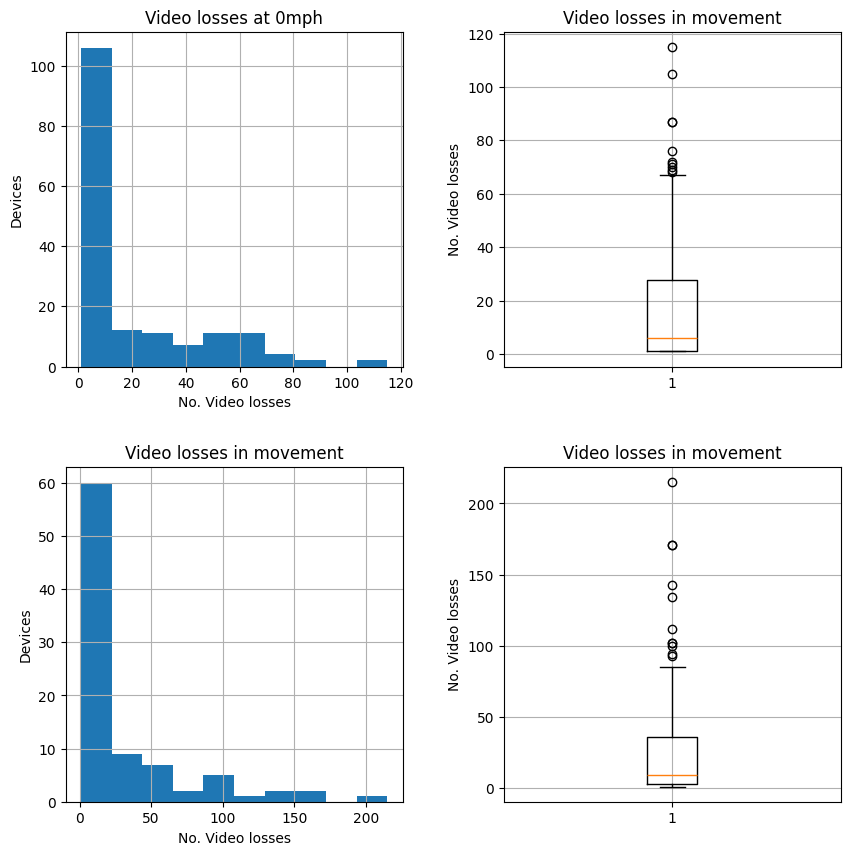

In [100]:
#### HISTOGRAM OF FAILURES WITH MOVING AND STOPPED VEHICLES ####
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

alarms_vehicles_stopped = alarms_speed_df[alarms_speed_df["Speed"] == 0]
alarms_vehicles_stopped = alarms_vehicles_stopped.groupby(["License plate number"])["License plate number"].value_counts()
alarms_vehicles_stopped = alarms_vehicles_stopped.to_frame().reset_index().rename(columns={"count":"Failures"})
alarms_vehicles_stopped.hist(ax=axs[0, 0])
plt.sca(axs[0,0])
plt.ylabel("Devices")
plt.xlabel("No. Video losses")
plt.title("Video losses at 0mph")
# plt.xticks(np.arange(0, 100, step=10))
# plt.yticks(np.arange(0, 100, step=10))

plt.sca(axs[0,1])
bp = plt.boxplot(alarms_vehicles_stopped['Failures'])
bp_info = get_box_plot_data(['Failures'],bp)
plt.ylabel("No. Video losses")
plt.title("Video losses in movement")
# plt.yticks(np.append(np.arange(0, 100, step=10),bp_info['median']))
plt.grid()

alarms_vehicles_moving = alarms_speed_df[alarms_speed_df["Speed"] > 0]
alarms_vehicles_moving = alarms_vehicles_moving.groupby(["License plate number"])["License plate number"].value_counts()
alarms_vehicles_moving = alarms_vehicles_moving.to_frame().reset_index().rename(columns={"count":"Failures"})
alarms_vehicles_moving.hist(ax=axs[1,0])
plt.sca(axs[1,0])
plt.ylabel("Devices")
plt.xlabel("No. Video losses")
plt.title("Video losses in movement")
# plt.xticks(np.arange(0, 100, step=10))
# plt.yticks(np.arange(0, 100, step=10))

plt.sca(axs[1,1])
bp = plt.boxplot(alarms_vehicles_moving['Failures'])
bp_info = get_box_plot_data(['Failures'],bp)
plt.ylabel("No. Video losses")
plt.title("Video losses in movement")
# plt.yticks(np.append(np.arange(0, 100, step=10),bp_info['median']))
plt.grid()

plt.show()       

In [101]:
# #EXPORT CONSOLIDATED DATA
outlier_devices
consolidated_alarms = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
consolidated_devices = active_devices_df[~ active_devices_df["License plate No."].isin(outlier_devices["License plate number"])]
from_date = consolidated_alarms['Alarm time'].min().strftime("%Y-%m-%d")
to_date = consolidated_alarms['Alarm time'].max().strftime("%Y-%m-%d")
filename = "consolidated_alarms_"+from_date+"_to_"+to_date+".xlsx"
display(filename)
consolidated_alarms.to_excel(filename)
filename = "consolidated_devices_"+from_date+"_to_"+to_date+".xlsx"
consolidated_devices.to_excel(filename)

consolidated_alarms_group = consolidated_alarms.groupby(["Fleet","License plate number"])["License plate number"].value_counts()
consolidated_alarms_group = consolidated_alarms_group.to_frame().reset_index().rename(columns={"count":"Failures"})
filename = "consolidated_alarms_count_"+from_date+"_to_"+to_date+".xlsx"
consolidated_alarms_group.to_excel(filename)

outlier_alarms = alarms_df[alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
filename = "outlier_alarms_"+from_date+"_to_"+to_date+".xlsx"
outlier_alarms.to_excel(filename)

outlier_alarms_group = outlier_alarms.groupby(["Fleet","License plate number"])["License plate number"].value_counts()
outlier_alarms_group = outlier_alarms_group.to_frame().reset_index().rename(columns={"count":"Failures"})
filename = "outlier_alarms_count_"+from_date+"_to_"+to_date+".xlsx"
outlier_alarms_group.to_excel(filename)


'consolidated_alarms_2024-01-01_to_2024-03-23.xlsx'

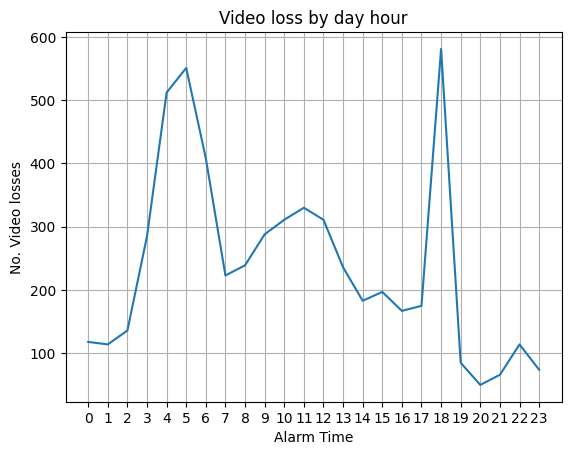

In [102]:
consolidated_failures = consolidated_alarms.copy()
consolidated_failures["Alarm time"] = pd.to_datetime(consolidated_failures["Alarm time"])

date_grouper = consolidated_failures["Alarm time"].dt.hour

consolidated_failures = consolidated_failures.groupby([date_grouper])["Type"].value_counts()
consolidated_failures = consolidated_failures.to_frame().reset_index().rename(columns={"count":"Failures"})

plt.plot(consolidated_failures["Alarm time"], consolidated_failures["Failures"])
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel("Alarm Time")
plt.ylabel("No. Video losses")
plt.title("Video loss by day hour")
plt.grid()
plt.show()

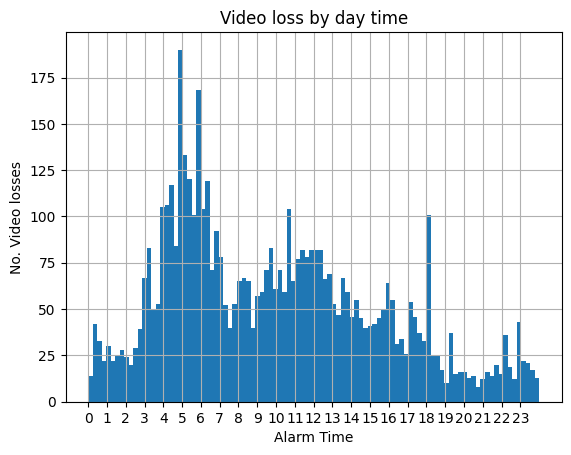

In [103]:
consolidated_failures = consolidated_alarms.copy()
consolidated_failures["Alarm time"] = pd.to_datetime(consolidated_failures["Alarm time"])

date_grouper = consolidated_failures["Alarm time"].dt.time

consolidated_failures = consolidated_failures.groupby(["License plate number",date_grouper])["Type"].value_counts()
consolidated_failures = consolidated_failures.to_frame().reset_index()

consolidated_failures["Alarm time"] = consolidated_failures["Alarm time"].apply(lambda x: (x.hour*60*60)+(x.minute*60)+(x.second))/(60*60)
consolidated_failures.hist(column="Alarm time", bins=100)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel("Alarm Time")
plt.ylabel("No. Video losses")
plt.title("Video loss by day time")
plt.show()

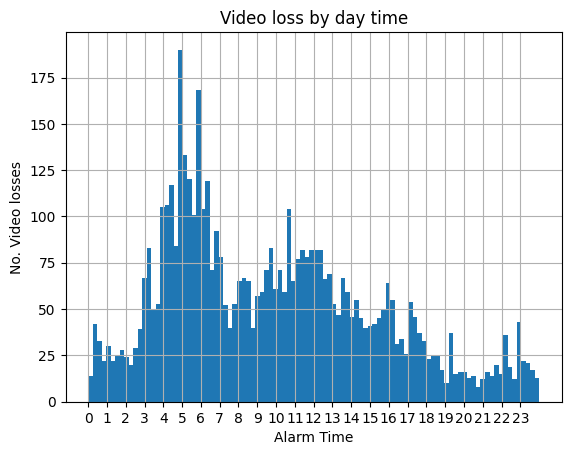

In [104]:
consolidated_failures = consolidated_alarms.copy()
consolidated_failures["Alarm time"] = pd.to_datetime(consolidated_failures["Alarm time"])
consolidated_failures = consolidated_failures[(consolidated_failures["Alarm time"].dt.time<datetime.time(hour=17, minute=59,second=59)) |
                            (consolidated_failures["Alarm time"].dt.time>datetime.time(hour=18, minute=0,second=1)) ]

date_grouper = consolidated_failures["Alarm time"].dt.time

consolidated_failures = consolidated_failures.groupby(["License plate number",date_grouper])["Type"].value_counts()
consolidated_failures = consolidated_failures.to_frame().reset_index()

consolidated_failures["Alarm time"] = consolidated_failures["Alarm time"].apply(lambda x: (x.hour*60*60)+(x.minute*60)+(x.second))/(60*60)
consolidated_failures.hist(column="Alarm time", bins=100)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel("Alarm Time")
plt.ylabel("No. Video losses")
plt.title("Video loss by day time")
plt.show()

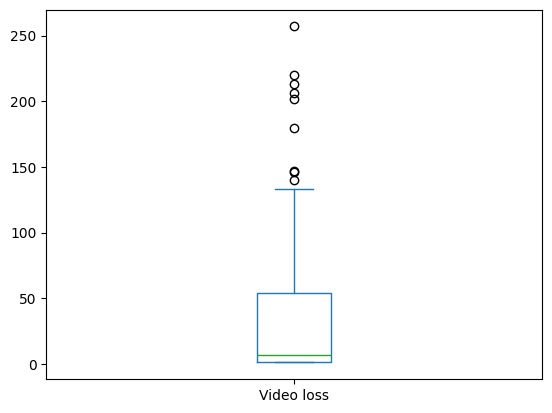

,License plate number,Type,Video loss
2,007100404F,Video Loss Alarm,54
5,0071004109,Video Loss Alarm,106
9,00710041B5,Video Loss Alarm,81
10,00710041FB,Video Loss Alarm,109
23,00710044DE,Video Loss Alarm,87
24,00710044FF,Video Loss Alarm,206
26,0071004528,Video Loss Alarm,73
28,00710045A9,Video Loss Alarm,147
32,00710045FB,Video Loss Alarm,89
34,0071004645,Video Loss Alarm,90


In [105]:
outlier_failures = consolidated_alarms.copy()

outlier_failures = outlier_failures[(outlier_failures["Alarm time"].dt.time>=datetime.time(hour=17, minute=59,second=59)) |
                            (outlier_failures["Alarm time"].dt.time<=datetime.time(hour=18, minute=0,second=1)) ]

outlier_failures_group_by_device = outlier_failures.groupby(["License plate number"])["Type"].value_counts().to_frame().reset_index().rename(columns={"count":"Video loss"})
outlier_failures_group_by_device.plot.box()
plt.show()
display(outlier_failures_group_by_device[outlier_failures_group_by_device["Video loss"]>30])

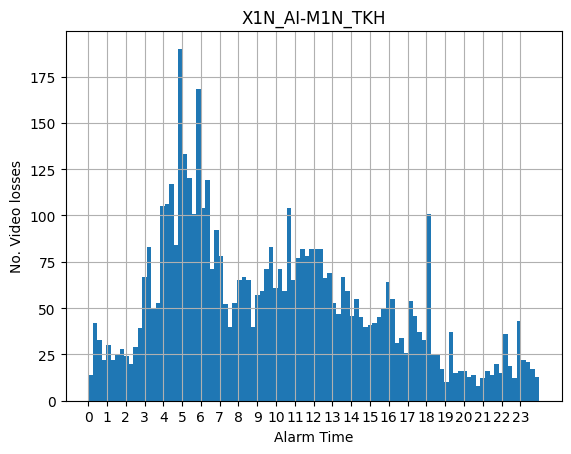

In [106]:

active_devices_df['Device model'].unique()

for model in active_devices_df['Device model'].unique():
    devices_by_model = active_devices_df[active_devices_df['Device model']==model]
    
    consolidated_failures = alarms_df[alarms_df['License plate number'].isin(devices_by_model['License plate No.'])]
    consolidated_failures["Alarm time"] = pd.to_datetime(consolidated_failures["Alarm time"])
    date_grouper = consolidated_failures["Alarm time"].dt.time

    consolidated_failures = consolidated_failures.groupby(["License plate number",date_grouper])["Type"].value_counts()
    consolidated_failures = consolidated_failures.to_frame().reset_index()
    
    consolidated_failures["Alarm time"] = consolidated_failures["Alarm time"].apply(lambda x: (x.hour*60*60)+(x.minute*60)+(x.second))/(60*60)
    if(consolidated_failures.size>0):
        consolidated_failures.hist(column="Alarm time", bins=100)
        plt.xticks(np.arange(0, 24, step=1))
        plt.xlabel("Alarm Time")
        plt.ylabel("No. Video losses")
        plt.title(model)
        plt.show()